# Derive wind anomaly from temperature anomaly based on the thermal wind balance

original python script developed by Nicole Albern, KIT, 2022 was set up for a dry atmosphere

modifications by Christoph Braun, KIT, July 2023 to check the impact of using moist instead of dry atmosphere on the derived wind anomaly

## First some steps that can be done w/o distinction between dry and moist atmosphere

### import required libraries

In [1]:
import numpy as np
from netCDF4 import Dataset

import scipy.integrate

from numba import jit

import matplotlib.pyplot as plt

import netCDF4 as nc

### 1) load information of vertical levels

In [2]:
def load_levelinfo():
    
    fpath = '/work/bb1152/Module_A/A6_CyclEx/input_data/'
    file = Dataset(fpath+'ifs2icon_verticalgridinfo_137levels.nc', 'r')
    hyam = np.squeeze(np.array(file.variables['hyam']))
    hybm = np.squeeze(np.array(file.variables['hybm']))   
    hyai = np.squeeze(np.array(file.variables['hyai']))
    hybi = np.squeeze(np.array(file.variables['hybi']))   
    lev  = np.squeeze(np.array(file.variables['lev' ]))
    lev_2= np.squeeze(np.array(file.variables['lev_2']))    
    return hyam, hybm, hyai, hybi, lev, lev_2

In [3]:
hyam, hybm, hyai, hybi, lev, lev_2 = load_levelinfo()

### 2) define constants

physical constants are taken from

- Polvani and Esler, 2007
- Booth et al., 2013 Climate Dynamics
- or set to the values used in icon-nwp-2.0.15/src/shared/mo_physical_constants.f90

In [4]:
u0     = 45.0           # in m/s (as in Polvani and Esler, 2007)
zT     = 13.0e3         # in m (as in Polvani and Esler, 2007)
H      = 7.5e3          # in m (as in Polvani and Esler, 2007)
R      = 287.04         # dry gas constant in J/(kg K) (parameter rd in ICON)
a      = 6.371229e6     # average Earth radius in m (parameter earth_radius in ICON)
Omega  = 7.29212e-5     # angular velocity in 1/s (parameter earth_angular_velocity in ICON) 
T0     = 300            # in K (as in Polvani and Esler, 2007)
Gamma0 = -6.5e-3        # in K/m (as in Polvani and Esler, 2007)
alpha  = 10             # unitless (as in Polvani and Esler, 2007)
kappa  = 2.0/7.0        # unitless (as in Polvani and Esler, 2007)
g      = 9.80665        # av. gravitational acceleration in m/s2 (parameter grav in ICON)
p0     = 1.0e5          # globally-uniform surface pressure in Pa (as in Polvani and Esler, 2007)
# for relative humidity following Booth et al., 2013 Climate Dynamics
zTrh   = 12.0e3        
rh0    = 0.80           # relative humidity scaling factor from 0..1

### 3) define vertical grid

for computation of initial state we convert the ifs2icon hybrid levels to height levels assuming a globally-uniform surface pressure (defined above) and defining height according to Polvani and Elsner as z = H ln (p0/p)

In [5]:
p  = hyam + hybm*p0
z  = H*np.log(p0/p)  # np.log is natural logarithm
nz   = z.size

### 4) define latitude-longitude grid

In [6]:
lat  = np.linspace(-90, 90, 360)
lon  = np.linspace(0.0,360,10)
nlat = lat.size
nlon = lon.size

# latitude in radians
latrad = lat * np.pi/180.0

### 5) define wind field for lifecycle 1 (as in Polvani and Esler, 2007; eqns 6 and 7)

In [7]:
u1 = np.zeros((nz,nlat))+np.nan
F1  = np.power(np.sin(np.pi*np.power(np.sin(latrad),2)),3); F1[lat<0] = 0.0
for i in range(0, nz):
    for j in range(0, nlat):
        u1[i,j] = u0*F1[j]*(z[i]/zT)*np.exp(-0.5*(np.power(z[i]/zT,2)-1))

### 6) define latitude independent reference temperature profile (as in Polvani and Esler, 2007; eqn A5)

In [8]:
Tr = np.zeros((nz, nlat)) + np.nan
for i in range(0, nz):
    Tr[i, :] = T0 + Gamma0/np.power((np.power(zT,-alpha)+np.power(z[i],-alpha)),1/alpha)

### 7) compute temperature profile in zonal wind balance with wind field (as in Polvani and Esler, 2007; eqn A4)
#### 7A) define integrand from eqn A4

In [9]:
@jit
def Tintegrand(latrad, z, zT, U0, a, Omega):
    f  = 2*Omega*np.sin(np.deg2rad(45.0))
    F  = np.power(np.sin(np.pi*np.power(np.sin(latrad),2)),3)
    if latrad<0: F=0.0
    u1 = U0*F*(z/zT)*np.exp(-0.5*(np.power(z/zT,2)-1))
    du1dz = u1*(1/z-z/np.power(zT,2))
    return (a*f+2*u1*np.tan(latrad))*du1dz

#### 7B) integrate

In [10]:
tmp = np.zeros((nz, nlat)) + np.nan
for i in range(0, nz):
    for j in range(0, nlat):
        tmp[i, j] =scipy.integrate.quad(Tintegrand, 0, latrad[j], args=(z[i], zT, u0, a, Omega))[0]

#### 7C) add integrand into eqn A4

In [11]:
Tctl=Tr-H/R*tmp

### 7) define relative humidity profile

follows Booth et al. 2013, Climate Dynamics 

In [12]:
rh = np.zeros((nz, nlat)) + np.nan
for i in range(0, nz):
    if z[i]>14e3:
        rh[i, :] = 0.0
    else:
        rh[i, :] = rh0*np.power(1-0.85*z[i]/zTrh, 1.25)

### 8) calculate qv for CTL

follows calculation in icon 

/icon-nwp-2.0.15/src/atm_phy_schemes/mo_satad.f90 -> sat_pres_water,spec_humi

In [13]:
def get_qv_0D(T,rh,p):
    
    # define constants
    b1 = 610.78  # --> c1es in mo_convect_tables.f90 
    b2w= 17.269  # --> c3les 
    b3 = 273.15  # --> tmelt; melting temperature in K
    b4w= 35.86   # --> c4les

    Rdv = 287.04/461.51   # Rd/Rv; replace Rd by R as values are identical?
    o_m_Rdv = 1-Rdv       # 1-Rd/Rv
    
    sat_pres_water = b1*np.exp(b2w*(T-b3)/(T-b4w))

    qv = rh*Rdv*sat_pres_water/(p-o_m_Rdv*sat_pres_water) # Do I understand this equation?
            
    return qv

In [14]:
qvctl = np.zeros((nz, nlat))
for i in range(0, nz):
    for j in range(0, nlat):
        qvctl[i, j] = get_qv_0D(Tctl[i,j],rh[i,j],p[i])

### 9) calculate Tv for CTL

based on https://glossary.ametsoc.org/wiki/Virtual_temperature

In [15]:
def get_Tv(T,qv):
    return (1+0.61*qv)*T

In [16]:
Tvctl = get_Tv(Tctl,qvctl)

### 10) define temperature anomaly

In [17]:
Tanom = np.ones((nz,nlat))*4.0

### 11) calculate T for +4K

In [18]:
T4K = Tctl + Tanom

### 12) calculate qv for +4K

In [19]:
qv4K = np.zeros((nz, nlat))
for i in range(0, nz):
    for j in range(0, nlat):
        qv4K[i, j] = get_qv_0D(T4K[i,j],rh[i,j],p[i])

### 13) calculate Tv for +4K

In [20]:
Tv4K = get_Tv(T4K,qv4K)

### 14) Calculate Tv anomaly

In [21]:
dTv = Tv4K - Tvctl

### 15) calculate zonal wind anomaly based on temperature anomaly

#### 15A) define function to calculate the meridional gradient of variable "var"

In [22]:
def get_dxdlat(var, lats, levs):
    nlat = lats.size # length of latitude vector
    # calculate distance between entries of latitude vector
    dlat = np.full(lats.shape, np.nan, dtype=float)
    dlat[0] = np.abs(lats[1] - lats[0])
    # distance between lat[2]-lat[0], lat[3]-lat[1], etc.
    dlat[1:nlat-1] = np.abs(lats[2:nlat] - lats[0:nlat-2])
    dlat[nlat-1] = np.abs(lats[nlat-1] - lats[nlat-2])

    # check that first dimension is levs and second dimension is lats
    if (var.shape[0] == levs.size) and (var.shape[1] == lats.size):
        # check that latitudes go from south to north
        if lats[0] > lats[1]:
            var = var[:, ::-1]
            lats = lats[::-1]
            print('changed lats and var')

        # centered finite differences
        var_grad = np.full(var.shape, np.nan, dtype=float)
        var_grad[:, 0] = (var[:, 1] - var[:, 0]) / dlat[0]
        for la in range(1, nlat-1):
            var_grad[:, la] = (var[:, la+1] - var[:, la-1]) / dlat[la]
        del la
        var_grad[:, nlat-1] = (var[:, nlat-1] - var[:, nlat-2]) / dlat[nlat-1]
    else:
        print('ERROR: Dimensions are not lat and lev. ' + \
              'Exit function get_dxdlat')
        return

    return var_grad

#### 15B) define function to calculate the zonal wind from atm. temperature following thermal wind balance

In [24]:
def get_u_from_t(tanom, z, lat, latrad, bsmooth=False, bgradout=False):
# input: tanom: atmospheric temperature anomaly, dimensions (zin-lat)
#        tropo: tropopause height in m
#        zin: vertical levels of temperature field in m
#        zout: vertical levels of zonal wind field in m
#        lat: latitudes of temperature field in degree
#        latrad: latitudes in radian

    # 1. prepare the temperature field
    # 1.1 We want to derive the zonal wind from the surface to TOA.
    #     If levels do not go from surface to TOA, change them.
    if z[0] > z[1]:
        print('change order of z to go from surface to TOA')
        tanom_calc = tanom[::-1, :]
        z_calc = z[::-1]
    else:
        tanom_calc = tanom.copy()
        z_calc = z.copy()
    del tanom, z

    ################################################################### 
    # 2. calculate the zonal wind field
    # 2.1 helper variables
    f = 2*Omega*np.sin(np.deg2rad(45.0))
    var_a = -1*H*a*f/R
    var_b = -2*H*np.tan(latrad)/R

    # 2.2 meridional temperature gradient
    dTdlat = get_dxdlat(tanom_calc, latrad, z_calc)
    
    # smooth the meridional temperature gradient; cehck whether needed
    if bsmooth:
        window = np.ones(20)/20
        dTdlat_runmean = np.full(dTdlat.shape, np.nan, dtype=float)
        for le in range(len(zin_int)):
            dTdlat_runmean[le, :] = np.convolve(dTdlat[le, :], window, 'same')
        del le, window
        del dTdlat
        dTdlat = dTdlat_runmean
    
    # 2.3 difference between levels
    #     array has one entry less than z: first entry is
    #     the difference between the first and second level
    dz = np.diff(z_calc)

    # 2.4 calculate zonal wind
    uanom_int = np.full(tanom_calc.shape, np.nan, dtype=float)

    # no wind at the surface
    uanom_int[0, :] = 0.0

    # other levels
    for le in range(1, len(z_calc)): # loop over levels
        uanom_int[le, :] = (dTdlat[le-1,:] + \
                            var_a * uanom_int[le-1,:] / dz[le-1] + \
                            var_b * uanom_int[le-1,:] * uanom_int[le-1,:] / dz[le-1]) * \
                           dz[le-1] / (var_a + var_b * uanom_int[le-1,:])
    del le
    del f, var_a, var_b, dz
    
    # 3 invert vertical order of wind field again (similar for gradient below)
    uanom = uanom_int[::-1, :]
    
    if bgradout:
        dTdlat_flipped = dTdlat[::-1, :]
        return uanom, dTdlat_flipped
    else:
        return uanom

#### 15C) Check procedure by recalculating u1 for CTL

In [25]:
[u1ctl, dTdlat] = get_u_from_t(Tctl, z, lat, latrad, bgradout=True)

change order of z to go from surface to TOA


In [68]:
def plot_zonfield(var,clabel,vmin=None,vmax=None,levels=None,cmap='viridis',ymax=50,alpha=1):
    
    if (vmin or vmax or levels):
        levels = np.linspace(vmin,vmax,levels)
        cbar = plt.contourf(lat,z/1e3,var,levels=levels,cmap=cmap,alpha=alpha)
    else:
        cbar = plt.contourf(lat,z/1e3,var,cmap=cmap,alpha=alpha)
        
    plt.xlim(0,90)
    plt.ylim(0,ymax)
    plt.xlabel('latitude [°N]')
    plt.ylabel('height [km]')
    
    plt.colorbar(cbar,label=clabel)
    
    return

In [84]:
def plot_zonfield_contour(var,color='k',vmin=None,vmax=None,levels=None,cmap='viridis',ymax=50):
    
    lw=1
    
    if (vmin or vmax or levels):
        levels = np.linspace(vmin,vmax,levels)
        plt.contour(lat,z/1e3,var,levels=levels,colors=color,linewidths=lw)
    else:
        plt.contour(lat,z/1e3,var,colors=color,linewidths=lw)
        
    plt.xlim(0,90)
    plt.ylim(0,ymax)
    plt.xlabel('latitude [°N]')
    plt.ylabel('height [km]')
    
    return

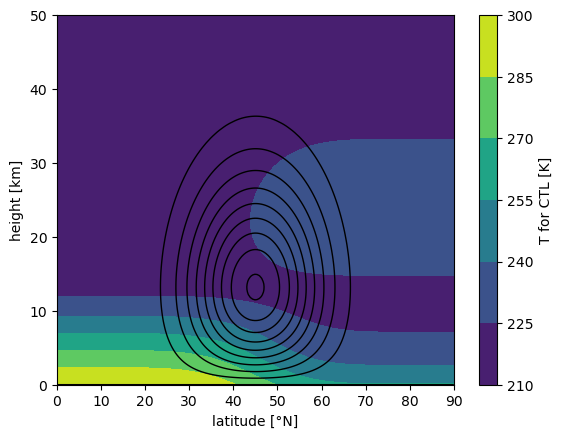

In [106]:
plot_zonfield(Tctl,'T for CTL [K]',alpha=1)
plot_zonfield_contour(u1ctl,vmin=0,vmax=50,levels=11)

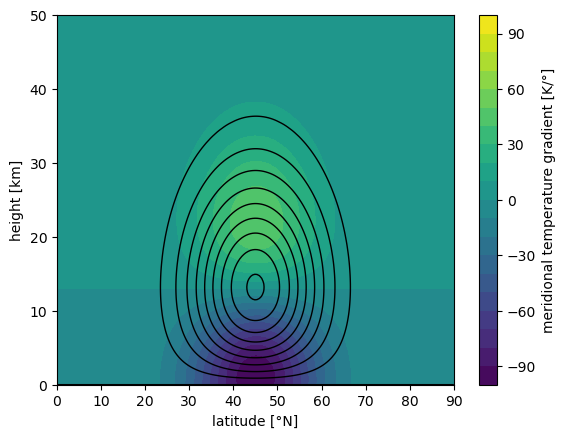

In [107]:
plot_zonfield(dTdlat,'meridional temperature gradient [K/°]',vmin=-100,vmax=100,levels=21)
plot_zonfield_contour(u1ctl,vmin=0,vmax=50,levels=11)

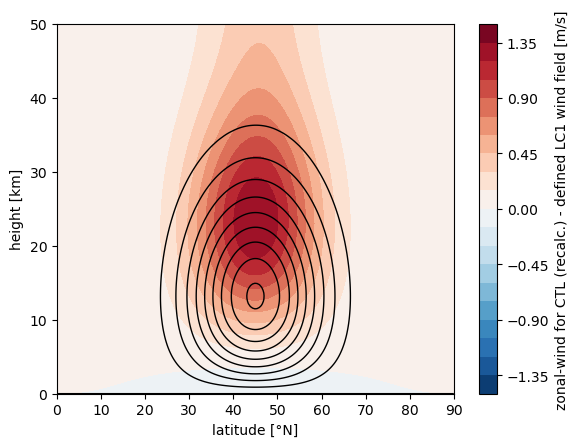

In [108]:
plot_zonfield(u1ctl-u1,'zonal-wind for CTL (recalc.) - defined LC1 wind field [m/s]',vmin=-1.5,vmax=1.5,levels=21,cmap='RdBu_r')
plot_zonfield_contour(u1ctl,vmin=0,vmax=50,levels=11)

In [109]:
# mask values with very low u1
rel_diff_u1ctl = np.where(u1>0.1,(u1ctl-u1)/u1*100,np.nan)

/tmp/ipykernel_903761/1758597521.py:2: RuntimeWarning: invalid value encountered in divide
  rel_diff_u1ctl = np.where(u1>0.1,(u1ctl-u1)/u1*100,np.nan)


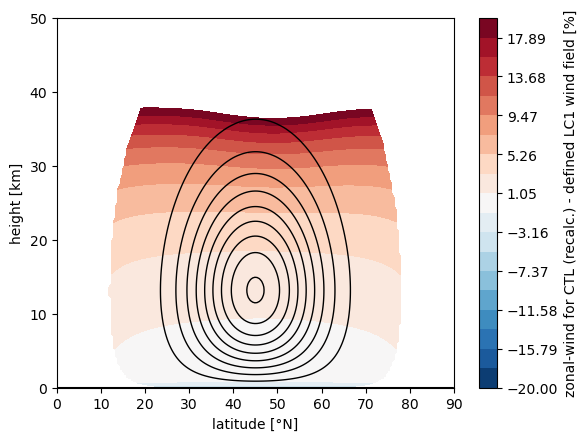

In [110]:
plot_zonfield(rel_diff_u1ctl,'zonal-wind for CTL (recalc.) - defined LC1 wind field [%]',vmin=-20,vmax=20,levels=20,cmap='RdBu_r')
plot_zonfield_contour(u1ctl,vmin=0,vmax=50,levels=11)

Seems to be roughly ok. Or do we expect exact matching?

#### 15D) Calculate u-anomaly and u+4K

In [33]:
uanom = get_u_from_t(dTv, z, lat, latrad)

change order of z to go from surface to TOA


In [34]:
u4K = u1 + uanom

#### 15E) calculate absolute wind field from Tv+4K

In [35]:
u4K_direct = get_u_from_t(Tv4K, z, lat, latrad)

change order of z to go from surface to TOA


### 16) Plot results

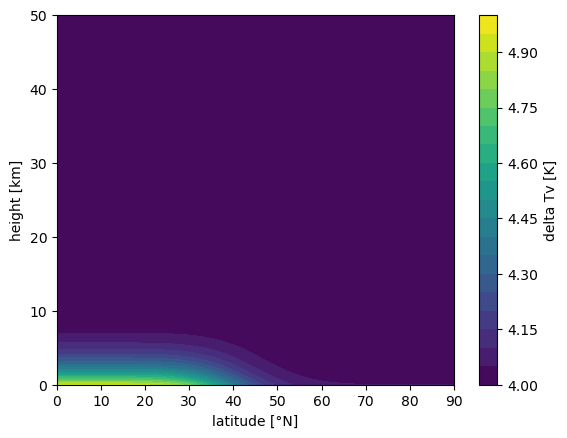

In [114]:
plot_zonfield(dTv,'delta Tv [K]',vmin=4,vmax=5,levels=21,ymax=50)

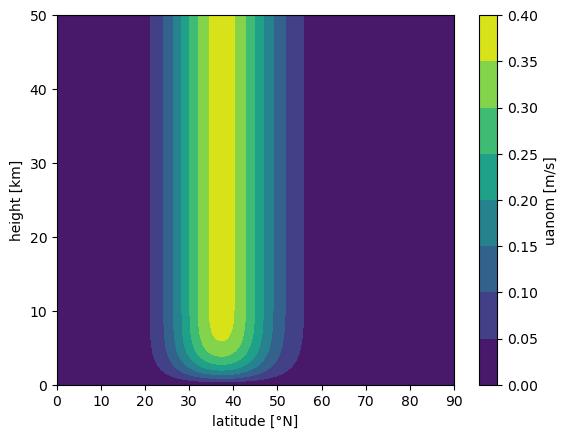

In [38]:
plot_zonfield(uanom,'uanom [m/s]')

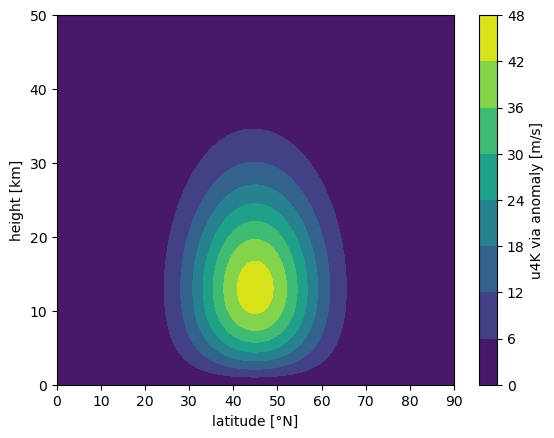

In [41]:
plot_zonfield(u4K,'u4K via anomaly [m/s]')

In [104]:
# mask values with very low u1
rel_diff_u4K = np.where(u1>0.1,(u4K-u1)/u1*100,np.nan)

/tmp/ipykernel_903761/509274964.py:2: RuntimeWarning: invalid value encountered in divide
  rel_diff_u4K = np.where(u1>0.1,(u4K-u1)/u1*100,np.nan)


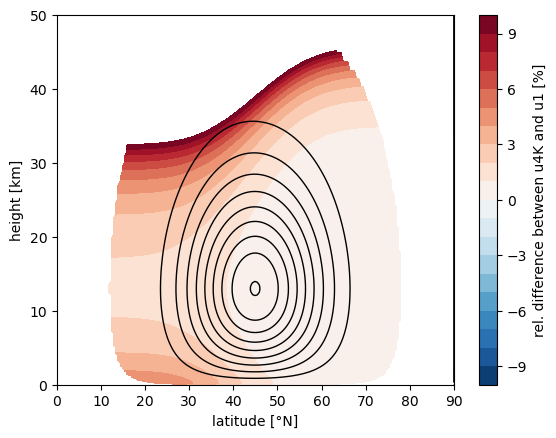

In [105]:
plot_zonfield(rel_diff_u4K,'rel. difference between u4K and u1 [%]',vmin=-10,vmax=10,levels=21,cmap='RdBu_r')
plot_zonfield_contour(u4K,vmin=0,vmax=50,levels=11)

## Investigate difference due to nonlinearity of calculation

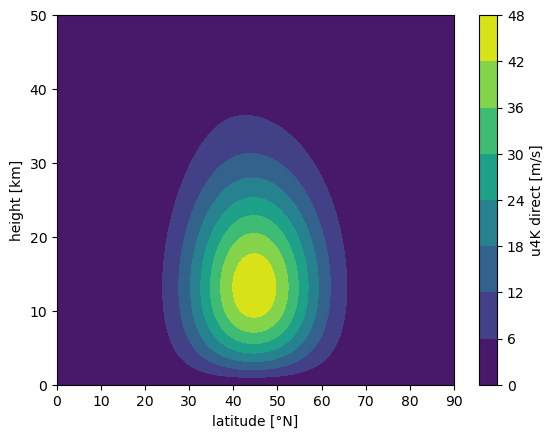

In [42]:
plot_zonfield(u4K_direct,'u4K direct [m/s]')

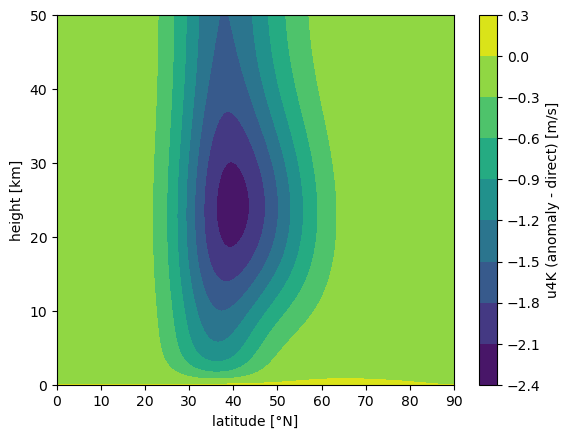

In [43]:
plot_zonfield(u4K-u4K_direct,'u4K (anomaly - direct) [m/s]')